In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import datetime

In [2]:
from statsmodels.tsa.stattools import coint, adfuller

## Test out examples of pairs trading

In [6]:
df = pd.read_csv("/Users/kunalchakraborty/Downloads/Appian/data/main_data.csv")

In [7]:
df.head()

,date,5. adjusted close,6. volume,9. Ticker Sym,returns,betas,Sector,Industry Group,Industry,Sub-Industry
0,1999-11-01,6.705801,159200.0,AEM,NaN,NaN,Materials,Materials,Metals & Mining,Gold
1,1999-11-02,6.507600,126900.0,AEM,-0.029557,NaN,Materials,Materials,Metals & Mining,Gold
2,1999-11-03,6.292882,87600.0,AEM,-0.032995,NaN,Materials,Materials,Metals & Mining,Gold
3,1999-11-04,6.243332,129400.0,AEM,-0.007874,NaN,Materials,Materials,Metals & Mining,Gold
4,1999-11-05,5.987322,104000.0,AEM,-0.041005,NaN,Materials,Materials,Metals & Mining,Gold


In [8]:

def stationarity_test(X, cutoff=0.01):
    # H_0 in adfuller is unit root exists (non-stationary)
    # We must observe significant p-value to convince ourselves that the series is stationary
    pvalue = adfuller(X)[1]
    if pvalue < cutoff:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')

In [9]:
def normalize_price(X, method="std"):
    return (X - X.mean())/X.std()

In [10]:
def check_cointegration(X, Y):
    """ Run all possible tests of cointegration"""

    ## Ensure their size is the same
    datelist1 = set(X.index)
    datelist2 = set(Y.index)
    common_datelist = list(datelist1.intersection(datelist2))

    X = X[X.index.isin(common_datelist)].sort_index()
    Y = Y[Y.index.isin(common_datelist)].sort_index()

    ## Normalize their prices
    X = normalize_price(X)
    Y = normalize_price(Y)

    
    result = {}
    score, pvalue, _ = coint(X,Y, trend="c")
    print("Cointegration test base with constant trend, pvalue = ", pvalue)
    result["constant"] = pvalue

    score, pvalue, _ = coint(X,Y, trend="c")
    print("Cointegration test base with linear trend, pvalue = ", pvalue)
    result["linear"] = pvalue

    score, pvalue, _ = coint(X,Y, trend="ctt")
    print("Cointegration test base with quadratic trend, pvalue = ", pvalue)
    result["quadratic"] = pvalue

    score, pvalue, _ = coint(X,Y, trend="nc")
    print("Cointegration test base with no trend, pvalue = ", pvalue)
    result["no_constant"] = pvalue

    return result

In [11]:
def extract_time_series(df, ticker, property, start_date=None, end_date=None):
    if not start_date:
        start_date = df["date"].min()
    if not end_date:
        end_date = df['date'].max()
    df = df[(df["date"] >= start_date) & (df["date"] <= end_date)]
    df = df.sort_values("date")
    df = df.set_index("date")
    return df[df["9. Ticker Sym"]==ticker][property]

In [12]:
## Tryout some co-integrated stocks in 
stock_tryout = ['AME-USA', 'APP-USA', 'ARKK-USA', 'CRNC-USA', 'CSIQ-USA',
       'DOV-USA', 'FLS-USA', 'GTES-USA', 'HLIO-USA', 'HYLN-USA']

stock_tryout = [x.split("-")[0] for x in stock_tryout]

In [13]:
from itertools import combinations
  
# All possible pairs in List
# Using combinations()
res = list(combinations(stock_tryout, 2))

In [14]:
def check_cointegration_for_tickers(stock_tryout, start_date, end_date):
    """ Check cointegration for a list of tickers
    and return a dictionary"""
    res = list(combinations(stock_tryout, 2))
    cointegration_info = {}
    for pair in res:
        print(pair)
        X,Y = pair[0], pair[1]
        X = extract_time_series(df,X,"5. adjusted close", start_date=start_date)
        Y = extract_time_series(df,Y,"5. adjusted close", start_date=start_date)
        cointegration_info[pair] = check_cointegration(X,Y)
    return cointegration_info

In [20]:
cointegration_info = {}
for pair in res:
    print(pair)
    X,Y = pair[0], pair[1]
    X = extract_time_series(df,X,"5. adjusted close", start_date="2021-01-01")
    Y = extract_time_series(df,Y,"5. adjusted close", start_date="2021-01-01")
    cointegration_info[pair] = check_cointegration(X,Y)

('AME', 'APP')
Cointegration test base with constant trend, pvalue =  0.010994280484320083
Cointegration test base with linear trend, pvalue =  0.010994280484320083
Cointegration test base with quadratic trend, pvalue =  0.012416675481413984
Cointegration test base with no trend, pvalue =  0.0017620187213532046
('AME', 'ARKK')
Cointegration test base with constant trend, pvalue =  0.1246696880328459
Cointegration test base with linear trend, pvalue =  0.1246696880328459
Cointegration test base with quadratic trend, pvalue =  0.4035580499318683
Cointegration test base with no trend, pvalue =  0.03158539950385292
('AME', 'CRNC')
Cointegration test base with constant trend, pvalue =  0.8648745848060269
Cointegration test base with linear trend, pvalue =  0.8648745848060269
Cointegration test base with quadratic trend, pvalue =  0.27040394542515855
Cointegration test base with no trend, pvalue =  0.6261609372430785
('AME', 'CSIQ')
Cointegration test base with constant trend, pvalue =  0.02

In [15]:
pair = ('CSIQ', 'HLIO')
X = extract_time_series(df,"CSIQ","5. adjusted close", start_date="2021-01-01")
Y = extract_time_series(df,"HLIO","5. adjusted close", start_date="2021-01-01")

In [25]:
## Strength of cointegration cannot be measured. It is a Yes/No phenomenon
def filter_cointegrated_pairs(co_dict, criteria, p_value):
    """ Filter cointegrated pairs on a criteria and given p value threshold """
    pairs = []
    for key,value in co_dict.items():
        if value[criteria] < p_value:
            pairs.append(key)
    return pairs

In [26]:
filter_cointegrated_pairs(cointegration_info, "constant", 0.01)

[('CSIQ', 'HLIO'), ('FLS', 'GTES')]

In [28]:
def get_common_dates(Y,X):
    datelist1 = set(X.index)
    datelist2 = set(Y.index)
    common_datelist = list(datelist1.intersection(datelist2))
    return common_datelist


def get_difference_series(Y,X):
    datelist = get_common_dates(Y,X)
    Y = Y[Y.index.isin(datelist)]
    X = X[X.index.isin(datelist)]
    return Y - X


def plot_individual_series(Y, title=""):
    Y.plot()
    plt.title(title)
    plt.xticks(rotation="45")

def get_stationary_series(Y,X):
    """ Try both ways """
    Beta_x = np.cov(Y,X)[0][1]/np.var(X)
    residual_x = Y - Beta_x*X
    # Perform ADF
    pvalue_x = adfuller(residual_x)[1]

    Beta_y = np.cov(Y,X)[0][1]/np.var(Y)
    residual_y = Y - Beta_y*Y
    # Perform ADF
    pvalue_y = adfuller(residual_y)[1]
    if pvalue_x < pvalue_y:
        print("Co-integration series = X")
        return residual_x
    else:
        print("Co-integration series = Y")
        return residual_y
    
def plot_common_series(Y,X, title, l1, l2):
    common_dates = get_common_dates(Y,X)
    Y = Y[Y.index.isin(common_dates)]
    X = X[X.index.isin(common_dates)]
    Y.plot(label =l2 )
    X.plot(label =l1)
    plt.title(title)
    plt.xticks(rotation="45")
    plt.legend()


In [17]:
for pairs in filter_cointegrated_pairs(cointegration_info, "constant", 0.01):
    plt.figure()
    plot_common_series(normalize_price(extract_time_series(df,pairs[0],"5. adjusted close", start_date="2021-01-01")),
                   normalize_price(extract_time_series(df,pairs[1],"5. adjusted close", start_date="2021-01-01")), title=pairs)


    plt.figure()
    plot_individual_series(get_stationary_series(normalize_price(extract_time_series(df,pairs[0],"5. adjusted close", start_date="2021-01-01")),
                                                 normalize_price(extract_time_series(df,pairs[1],"5. adjusted close", start_date="2021-01-01"))))

NameError: name 'filter_cointegrated_pairs' is not defined

In [18]:
def generate_mad_signals(tseries, threshold = 2, window=60):
    mad = lambda x: np.abs(x - x.median()).median()
    mad_series = tseries.rolling(window).apply(mad)
    mad_series = mad_series.dropna()

    median_series = tseries.rolling(window).median()
    median_series = median_series.dropna()

    datelist = get_common_dates(tseries, mad_series)
    tseries = tseries[tseries.index.isin(datelist)]
    mad_series = mad_series[mad_series.index.isin(datelist)]
    median_series = median_series[median_series.index.isin(datelist)]

    top_strategy = []
    value = 0
    trade_enter_up = False
    trade_enter_down = False
    for i in range(tseries.shape[0]):
        if tseries.iloc[i] > threshold*mad_series.iloc[i] and trade_enter_up == False:
            value = -1
            trade_enter_up = True
        elif tseries.iloc[i] < -threshold*mad_series.iloc[i] and trade_enter_down == False:
            value = 1
            trade_enter_down = True
        elif trade_enter_down == True and tseries.iloc[i] > median_series[i]:
            value = 0
            trade_enter_down = False
        elif trade_enter_up == True and tseries.iloc[i] < median_series[i]:
            value = 0
            trade_enter_up = False

        top_strategy.append(value)
    bottom_strategy = [-1*x for x in top_strategy]

    return top_strategy, bottom_strategy, datelist

In [19]:
def compute_profits(Y,X, top_strategy, bottom_strategy, datelist, cointegrating_series = "X"):
    Y = Y[Y.index.isin(datelist)]
    X = X[X.index.isin(datelist)]
    top_profit = 0
    bottom_profit = 0
    top_strategy = pd.Series(top_strategy, index = datelist)
    bottom_strategy = pd.Series(bottom_strategy, index = datelist)


    switch = False
    for sp in range(1,len(Y)):
        if top_strategy[sp] != 0:
            if switch == False:
                fp = sp
                switch = True
            else:
                top_profit+=Y.iloc[sp] - Y.iloc[fp]
        else:
            switch = False

    top_profit+=Y.iloc[sp] - Y.iloc[fp]

    for sp in range(1,len(X)):
        if bottom_strategy[sp] != 0:
            if switch == False:
                fp = sp
                switch = True
            else:
                bottom_profit+=X.iloc[sp] - X.iloc[fp]
        else:
            switch = False

    bottom_profit+=X.iloc[sp] - X.iloc[fp]

    if cointegrating_series == "X":
        bottom_profit = bottom_profit*abs(np.cov(Y,X)[0][1]/np.var(X))
    else:
        top_profit = top_profit*abs(np.cov(Y,X)[0][1]/np.var(Y))


    total_profit = top_profit + bottom_profit

    return top_profit, bottom_profit

### Experiment

In [20]:
## Create rolling predictions for 2021.
def AR1_forecasting(X, size):
    train, test = X[:-size], X[-size:]
    history = [x for x in train]
    predictions = []
    length = len(train)
    for t in range(len(test)):
        model = ARIMA(history, order=(1,0,0))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
    return predictions

In [21]:
## Rolling window training
residual_series = get_stationary_series(normalize_price(extract_time_series(df,"FLS","5. adjusted close", start_date="2021-01-01")),
                                                 normalize_price(extract_time_series(df,"GTES","5. adjusted close", start_date="2021-01-01")))

Co-integration series = X


In [22]:
def add_time(date, days=1):
    return date + datetime.timedelta(days)

In [23]:
def rolling_window_single_series_forecast(Series, window):
    """Currently 1 period testing"""
    total_datelist = Series.index.tolist()
    testing_datelist = total_datelist[window:]
    predictions = []
    for i in range(0,len(total_datelist) - window+1):
        train = Series.iloc[i:window+i+1]
        prediction = AR1_forecasting(train,size=1)
        predictions.append(prediction[0])
    return pd.Series(predictions[:-1], index = testing_datelist)

    

In [24]:
forecasted_deviations = rolling_window_single_series_forecast(residual_series,60)

/Users/kunalchakraborty/Downloads/MFE22_GRP13_SEM1/venv/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


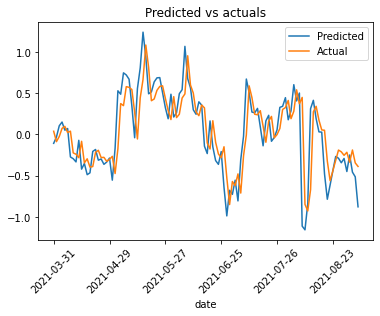

In [29]:
plot_common_series(residual_series, forecasted_deviations, "Predicted vs actuals", "Actual","Predicted")

In [30]:
## Compute deviations
differenced_series = get_difference_series(residual_series, forecasted_deviations)

<AxesSubplot:ylabel='Frequency'>

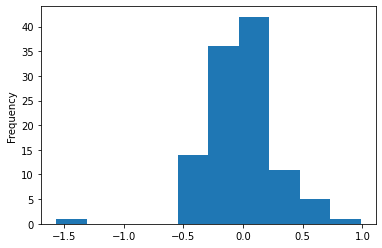

In [31]:
differenced_series.plot(kind="hist")

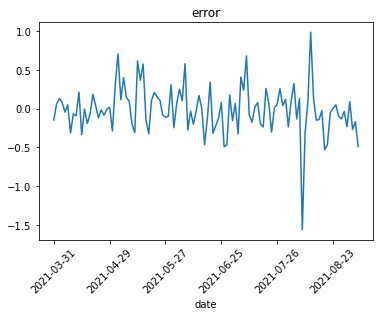

In [76]:
plot_individual_series(differenced_series,title="error")

In [86]:
top_strategy, bottom_strategy, datelist = generate_mad_signals(differenced_series)

In [124]:
lp, sp = compute_profits(Y, X, top_strategy, bottom_strategy, datelist, cointegrating_series = "X")
print("Profit from long position = ", lp)
print("Profit from short position = ", sp)

print("Total profit from static hedges = ", lp + sp)

Profit from long position =  -6.900988632099981
Profit from short position =  -0.7884699664081084
Total profit from static hedges =  -7.689458598508089


## Exploration of the trade

In [127]:
def plot_twin_axis(Y,X, y1_label, y2_label, title=""):
# create figure and axis objects with subplots()
    common_dates = get_common_dates(Y,X)
    Y = Y[Y.index.isin(common_dates)]
    X = X[X.index.isin(common_dates)]
    fig,ax = plt.subplots()
    # make a plot
    ax.plot(Y.index,Y.values, color="red", marker="o")
    # set x-axis label
    ax.set_xlabel("date",fontsize=14)
    # set y-axis label
    ax.set_ylabel(y1_label,color="red",fontsize=14)

    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(X.index, X.values,color="blue",marker="o")
    ax2.set_ylabel(y2_label,color="blue",fontsize=14)
    plt.show()

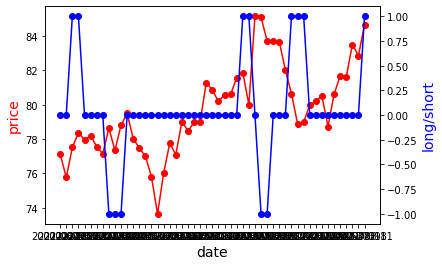

In [129]:
plot_twin_axis(Y, pd.Series(top_strategy, index=datelist),"price","long/short")

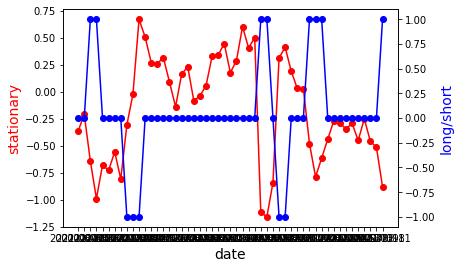

In [131]:
plot_twin_axis(residual_series, pd.Series(top_strategy, index=datelist),"stationary","long/short")

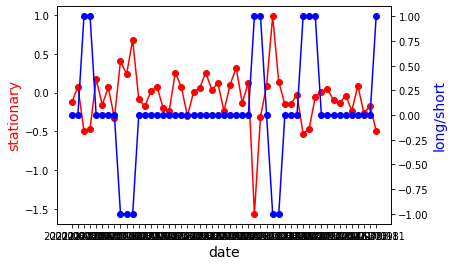

In [132]:
plot_twin_axis(differenced_series, pd.Series(top_strategy, index=datelist),"stationary","long/short")